In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import torch
import skorch
from skorch.helper import predefined_split
from skorch.dataset import Dataset

In [2]:
from functools import partial

In [3]:
import numpy as np

In [4]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

In [5]:
from deepspeech.model import DeepSpeech
from deepspeech.model import SequenceWise
from deepspeech.data.data_loader import SpectrogramParser
from deepspeech.data.data_loader import BucketingSampler

/home/nemo/envs/noswear/lib/python3.6/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [6]:
from noswear.data import dataset
from noswear.utils import RNNValueExtractor
from noswear.utils import Identity
from noswear.utils import bucketing_dataloader
from noswear.utils import filter_low_count_words
from noswear.layers import ResidualRNN
from noswear.model import bucket

We are building upon DeepSpeech CNN layers.

In [7]:
base_model = DeepSpeech.load_model(
    '../models/librispeech_pretrained.pth'
)
audio_conf = DeepSpeech.get_audio_conf(base_model)
parser = SpectrogramParser(audio_conf, normalize=True)
sampler = dataset.SOXSampler(sample_rate=audio_conf['sample_rate'])

We have our own swear/non-swear data, load it.

In [8]:
ds_swear = dataset.SwearDataset(base_path='../', providers=dataset.DEFAULT_PROVIDERS)

In [9]:
X_swear, y_swear = ds_swear.load()
len(X_swear), len(y_swear)

(270, 270)

In [10]:
ds = dataset.SwearBinaryAudioDataset(X_swear, y_swear, parser, sampler)

In [11]:
X, y = ds.load()
len(X), len(y)

(270, 270)

In [12]:
seq_lens = np.array([x.shape[1] for x in X])
max_seq_len = max(seq_lens)
max_seq_len, np.mean(seq_lens), np.median(seq_lens)

(299, 100.35185185185185, 76.0)

In [13]:
X_pad = np.zeros(
    (len(X), X[0].shape[0], max_seq_len), 
    dtype='float32'
)
for i, _ in enumerate(X):
    X_pad[i, :, :seq_lens[i]] = X[i]
    
y = np.array(y)

Filter low count words

In [14]:
idcs = filter_low_count_words(X_swear, min_count=4)
X_pad = X_pad[idcs]
y = y[idcs]

Splitting into train/valid/test

In [15]:
split = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [16]:
# use word as class for stratified split to make sure that train/test
# set both contain examples of the all words.
y_word = np.array([n[0] for n in X_swear])[idcs]
train_idcs_proto, test_idcs = next(split.split(y, y=y_word))

/home/nemo/envs/noswear/lib/python3.6/site-packages/scikit_learn-0.23.2-py3.6-linux-x86_64.egg/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [17]:
train_idcs, valid_idcs = next(split.split(y[train_idcs_proto], y=y_word[train_idcs_proto]))

/home/nemo/envs/noswear/lib/python3.6/site-packages/scikit_learn-0.23.2-py3.6-linux-x86_64.egg/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [18]:
train_idcs = train_idcs_proto[train_idcs]
valid_idcs = train_idcs_proto[valid_idcs]

Plot the class distribution (words)

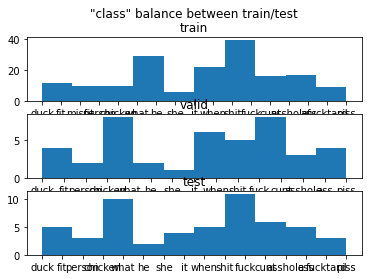

In [19]:
plt.subplot(311)
plt.title('"class" balance between train/test\ntrain')
plt.hist(y_word[train_idcs]);
plt.subplot(312)
plt.title('valid')
plt.hist(y_word[valid_idcs]);
plt.subplot(313)
plt.title('test')
plt.hist(y_word[test_idcs]);

In [20]:
X_train = {'lens': seq_lens[train_idcs], 'X': X_pad[train_idcs]}
y_train = np.array(y)[train_idcs].astype('float32')

X_valid = {'lens': seq_lens[valid_idcs], 'X': X_pad[valid_idcs]}
y_valid = np.array(y)[valid_idcs].astype('float32')

X_test = {'lens': seq_lens[test_idcs], 'X': X_pad[test_idcs]}
y_test = np.array(y)[test_idcs].astype('float32')

In [21]:
len(X_train['X']), len(X_valid['X']), len(X_test['X'])

(170, 43, 54)

Check if train/valid/test are balanced ($y \approx 0.5$)

In [22]:
y_train.mean(), y_valid.mean(), y_test.mean()

(0.4764706, 0.4651163, 0.46296296)

Model definition

In [170]:
class NoSwearModel(torch.nn.Module):
    def __init__(
        self, 
        base_model, 
        n_hidden=10, 
        n_layers=1,
        p_dropout=0.2,
        selector='last',
        inital_state_trainable=False,
    ):
        super().__init__()
        self.base_model = base_model
        self.base_model.rnns = Identity()
        self.base_model.lookahead = Identity()
        self.base_model.fc = Identity()
        self.base_model.inference_softmax = Identity()
        
        self.selector = selector
        
        self.rnn = torch.nn.LSTM(672, n_hidden, num_layers=n_layers, bias=False, batch_first=True)
        
        if inital_state_trainable:
            self.h0 = torch.nn.Parameter(torch.zeros(n_layers, 1, n_hidden))
            self.c0 = torch.nn.Parameter(torch.zeros(n_layers, 1, n_hidden))
        else:
            self.h0 = torch.zeros(n_layers, 1, n_hidden)
            self.c0 = torch.zeros(n_layers, 1, n_hidden)

        self.clf = torch.nn.Linear(n_hidden, 1, bias=False)
        self.dropout = torch.nn.Dropout(p=p_dropout)
        
        self.reset_parameters()
        
    def reset_parameters(self):
        self.rnn.reset_parameters()
        self.clf.reset_parameters()
        
    def forward(self, X, lens, h0=None, c0=None):
        # run base model, output is NxTxH with
        # T=Time, N=samples, H=hidden.
        y_pre = self.base_model(X)
        y_pre = self.dropout(y_pre)
        
        if not h0 or not c0:
            h0 = self.h0.repeat(1, X.shape[0], 1).to(X) 
            c0 = self.c0.repeat(1, X.shape[0], 1).to(X)
            
        # run RNN over sequence and extract "last" item
        y, (h1, c1) = self.rnn(y_pre, (
            h0,
            c0,
        ))
        
        if self.selector == 'designated':
            # instead of taking element -1 we just
            # designate neuron 0 to be our confidence indicator;
            # we take the element where [0] is greatest.
            indicator_seq = y[:, :, 0]
            idcs_time = indicator_seq.argmax(axis=-1)
            idcs_batch = list(range(X.shape[0]))
            indicator = indicator_seq[idcs_batch, idcs_time]

            # index using (batch, time) tuples
            y = y[idcs_batch, idcs_time, :]
        elif self.selector == 'designated_sum':
            ble = y
            indicator_seq = y[:, :, [0]*100].sum(dim=-1)
            idcs_time = indicator_seq.argmax(axis=-1)
            idcs_batch = list(range(X.shape[0]))
            indicator = indicator_seq[idcs_batch, idcs_time]

            y = y[idcs_batch, idcs_time, :]
        elif self.selector == 'designated_afew':
            # same as designated but look at at least N frames
            N = 10
            indicator_seq = y[:, N:, 0]
            idcs_time = indicator_seq.argmax(axis=-1)
            idcs_batch = list(range(X.shape[0]))
            indicator = indicator_seq[idcs_batch, idcs_time]
            
            y = y[idcs_batch, idcs_time, :]
        else:
            indicator = y[:, -1]
            indicator_seq = y[:, :]
            y = y[:, -1]
            
        y = self.clf(y)
        #y = torch.tanh(y)
        return y, indicator, indicator_seq, h1, c1

Training loop and stuff

In [171]:
class BinaryClassifier(skorch.classifier.NeuralNetBinaryClassifier):
    def get_loss(self, y_pred, y_true, *args, **kwargs):
        return super().get_loss(y_pred[0], y_true, *args, **kwargs)

In [205]:
torch.manual_seed(42)

net = BinaryClassifier(
    partial(NoSwearModel, base_model), 
    
    iterator_train=bucketing_dataloader,
    iterator_train__bucket_fn=bucket,
    iterator_train__shuffle=True,
    iterator_valid=bucketing_dataloader,
    iterator_valid__bucket_fn=bucket,
    
    batch_size=4,
    max_epochs=30,
    device='cuda',
    
    train_split=predefined_split(Dataset(X_valid, y_valid)),
    
    module__p_dropout=0.0,
    module__n_hidden=48,
    module__n_layers=1,
    module__selector='designated_afew',
        
    optimizer=torch.optim.Adam,
    optimizer__lr=0.0002,
    
    callbacks=[
        skorch.callbacks.Freezer('base_model.*'),
        skorch.callbacks.Checkpoint(monitor='valid_acc_best', f_pickle='model_valid_acc_best.pkl'),
        #skorch.callbacks.TrainEndCheckpoint(),
    ]
)

In [206]:
%pdb on
net.fit(X_train, y_train)

Automatic pdb calling has been turned ON
  epoch    train_loss    valid_acc    valid_loss    cp     dur
-------  ------------  -----------  ------------  ----  ------
      1        0.6983       0.5814        0.6727     +  0.9114
      2        0.6767       0.6047        0.6715     +  0.8546
      3        0.6596       0.6977        0.6660     +  0.8683
      4        0.6385       0.7209        0.6679     +  0.9258
      5        0.6265       0.6744        0.6573        0.8610
      6        0.5965       0.7209        0.6532        0.8559
      7        0.5703       0.6744        0.6396        0.9002
      8        0.5287       0.7209        0.6268        0.8872
      9        0.5005       0.6977        0.6068        0.8374
     10        0.4709       0.6512        0.6096        0.8809
     11        0.4230       0.6744        0.6042        0.8749
     12        0.4150       0.6977        0.5980        0.8532
     13        0.4039       0.7209        0.5964        0.8543
     14       

<class '__main__.BinaryClassifier'>[initialized](
  module_=NoSwearModel(
    (base_model): DeepSpeech(
      (conv): Sequential(
        (0): Conv2d(1, 32, kernel_size=(41, 11), stride=(2, 2), padding=(0, 10))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=0, max_val=20, inplace=True)
        (3): Conv2d(32, 32, kernel_size=(21, 11), stride=(2, 1))
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): Hardtanh(min_val=0, max_val=20, inplace=True)
      )
      (rnns): Identity()
      (fc): Identity()
      (inference_softmax): Identity()
      (lookahead): Identity()
    )
    (rnn): LSTM(672, 48, bias=False, batch_first=True)
    (clf): Linear(in_features=48, out_features=1, bias=False)
    (dropout): Dropout(p=0.0, inplace=False)
  ),
)

Training done, let's look at the accuracy of the best net (via valid loss)

In [207]:
net.load_params(checkpoint=dict(net.callbacks_)['Checkpoint'])

In [208]:
accuracy_score(y_valid, net.predict(X_valid))

0.7906976744186046

In [209]:
accuracy_score(y_test, net.predict(X_test))

0.7962962962962963

Let's inspect the indicator neuron (what does it do)

In [141]:
outputs = list(net.forward_iter(X_valid))

It seems to strongly, inversely correlate with the predicted output class

In [142]:
class_log, indicator_log, indicator_sequence_log, hX, cX = zip(*outputs)
class_log = torch.cat(class_log)
indicator_log = torch.cat(indicator_log)

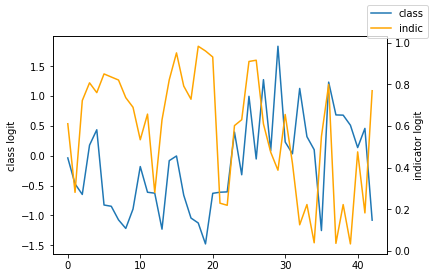

In [143]:
plt.plot(class_log)
plt.ylabel('class logit')

ax = plt.twinx()
ax.plot(indicator_log, c='orange')
plt.ylabel('indicator logit')

plt.gcf().legend(['class', 'indic']);

How does it evolve in time?

In [144]:
# since we have batched processing, we remove the batch dimension
# outputs.shape = (len(X_valid), 4, ?) => (len(X_valid), 4*?)
def debatch_indicator_sequences(outputs):
    def a():
        for _, _, indicator_seqs, _, _ in outputs:
            for seq in indicator_seqs:
                yield seq
    return list(a())

In [145]:
indicator_sequences = debatch_indicator_sequences(outputs)

In [195]:
def plot_seq_base(indicator_sequence, clogit, fpath):
    swear = clogit >= 0.5
    title = f"{fpath} - swear: {swear}"
    
    plt.title(title)
    plt.plot(indicator_sequence)
    plt.legend(['indic. neuron'])
    
def plot_seq(i):
    sequence = indicator_sequences[i]
    clogit = class_log[i]
    fpath = np.array(X_swear)[valid_idcs][i][1]
    
    plot_seq_base(sequence, clogit, fpath)

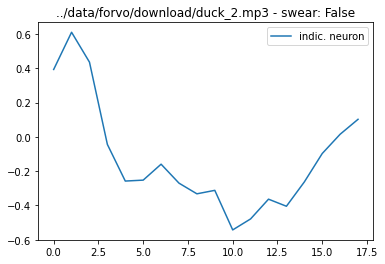

In [196]:
plot_seq(0)

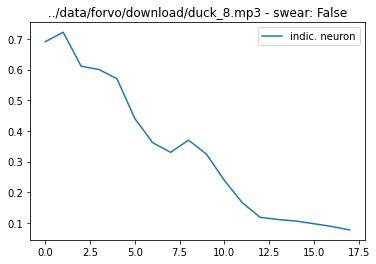

In [197]:
plot_seq(2)

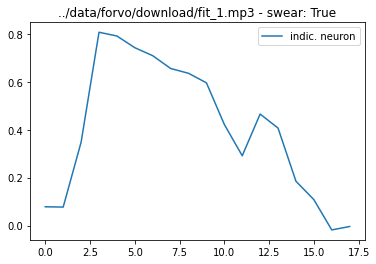

In [198]:
plot_seq(3)

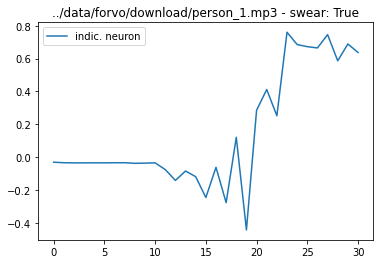

In [199]:
plot_seq(4)

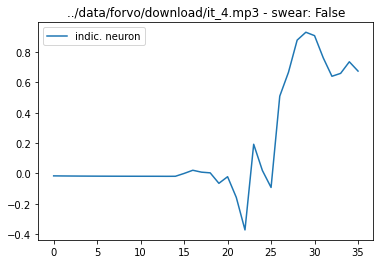

In [200]:
plot_seq(20)

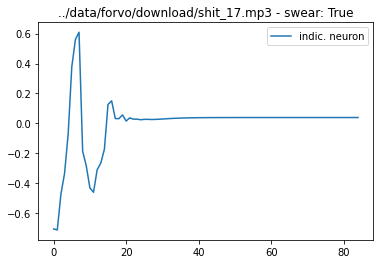

In [201]:
plot_seq(27)

Test on a single sample, a long-stretched 'shiiit'

In [202]:
audio_inp = parser.parse_audio('../data/own/shiiiit.ogg')
inp = {'X': audio_inp[None], 'lens': np.array([audio_inp.shape[1]])}

In [203]:
c, i, ics, hX, cX = zip(*list(net.forward_iter(inp)))

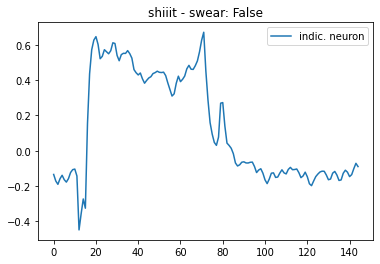

In [204]:
plot_seq_base(ics[0][0], c[0].item(), fpath='shiiit')

### grid search



In [45]:
from sklearn.model_selection import GridSearchCV
from skorch.helper import SliceDict

In [46]:
#net.initialize();
net.set_params(verbose=False);

In [47]:
params = {
    'optimizer__lr': [0.02, 0.002, 0.0002],
    'optimizer__weight_decay': [0, 1e-4],
    'optimizer': [torch.optim.RMSprop, torch.optim.Adam],
    'module__p_dropout': [0, 0.5],
    'module__n_hidden': [10, 100, 200, 400],
    'module__n_layer': [1, 2],
}

In [48]:
cv = TODO

NameError: name 'TODO' is not defined

> <ipython-input-48-6fbe553952be>(1)<module>()
----> 1 cv = TODO

ipdb> q


In [ ]:
gs = GridSearchCV(net, params, scoring='accuracy', cv=cv)

In [ ]:
%%time
gs.fit(SliceDict(**X_train), y_train);

In [ ]:
import pandas as pd
results = pd.DataFrame(gs.cv_results_)

In [ ]:
top_results = results.sort_values(by='mean_test_score').head(10)

In [ ]:
top_results

In [ ]:
top_results.params

In [ ]:
net.set_params(verbose=True, **top_results.params.iloc[1]);

In [ ]:
net.fit(X_train, y_train);

In [ ]:
accuracy_score(y_test, net.predict(X_test))